# Enunciado

![ej](/Users/athinasalim/Metodos_2025/newton/imgs/ej.jpeg)



Este gráfico es simplemente para ver donde podemos poner la semilla inicial para newton

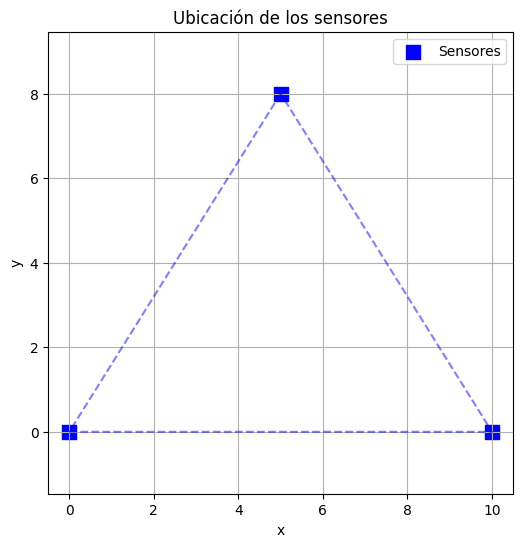

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
sensores = pd.read_csv("sensores.csv")
sensor_positions = sensores.values
plt.figure(figsize=(6,6))
plt.scatter(sensor_positions[:,0], sensor_positions[:,1], c="blue", marker="s", s=100, label="Sensores")
plt.plot(sensor_positions[:,0], sensor_positions[:,1], 'b--', alpha=0.5)
plt.plot([sensor_positions[-1,0], sensor_positions[0,0]],
         [sensor_positions[-1,1], sensor_positions[0,1]], 'b--', alpha=0.5)

plt.xlabel("x"); plt.ylabel("y")
plt.title("Ubicación de los sensores")
plt.legend(); plt.grid(True)
plt.axis("equal")
plt.show()

In [ ]:
import numpy as np
# --- Cargar datos ---
sensores = pd.read_csv("sensores.csv")
medidas = pd.read_csv("medidas.csv")
trayectoria = pd.read_csv("trayectoria.csv")

ground_truth = trayectoria[["x", "y"]].values   # (T,2)
sensor_positions = sensores.values        # (3, 2)  -> (x1,y1),(x2,y2),(x3,y3), 3 filas 2 columnas
times = medidas["t"].values               # (T,) vector 1D
dists = medidas[["d1","d2","d3"]].values  # (T, 3) T filas de 3 columnas

# NEWTON–RAPHSON CLÁSICO (sistema 2x2 usando 3 ecuaciones)
# Usamos diferencias de rangos para armar 2 ecuaciones:
# g1(x,y) = r1 - r3 - (d1 - d3) = 0
# g2(x,y) = r2 - r3 - (d2 - d3) = 0
# con r_i = sqrt((x-xi)^2 + (y-yi)^2)

#Ver elevar al cuadrado y convexidad.

#es como una funcion de "residuos" la cual utilizamos para poder tener las 2 ecuaciones que necesitamos en 2D para aplicar Newton. 
#No se ignora la informacón de ninguno de los sensores.
#r1, r2, r3 se evaluan en (x,y) d1, d2, d3 es la información que se nos da de los sensores a la partícula en un tiempo dado. La idea es encontrar x,y tal que
#r1(x, y) = d1
#r2(x,y) = d2
#r3(x,y) = d3
# en cada momento (un (x,y) por cada t)

def _ranges(X, sensors, eps=1e-12):
    diffs = X - sensors # calcula los vectores (x -x_i , y - y_i) para cada sensor
    rs = np.sqrt((diffs**2).sum(axis=1)) + eps
    return rs, diffs        

def g(X, d, sensors):
    rs, _ = _ranges(X, sensors)
    return np.array([
        (rs[0] - rs[2]) - (d[0] - d[2]),
        (rs[1] - rs[2]) - (d[1] - d[2]),
    ])

def Jg(X, sensors):
    rs, diffs = _ranges(X, sensors)
    # grad r_i = ( (x-xi)/ri , (y-yi)/ri )
    dr1 = diffs[0] / rs[0]
    dr2 = diffs[1] / rs[1]
    dr3 = diffs[2] / rs[2]
    # Jacobiano 2x2 de [g1, g2]
    # g1 = r1 - r3 - const  -> ∇g1 = dr1 - dr3
    # g2 = r2 - r3 - const  -> ∇g2 = dr2 - dr3
    J = np.vstack([dr1 - dr3, dr2 - dr3])  # (2,2)
    return J

def newton_raphson_2x2(X0, d, sensors, tol=1e-8, max_iter=30):
    """
    Newton–Raphson clásico para el sistema 2x2 g(X)=0.
    Retorna: (solución, historial_de_iterados)
    """
    X = np.array(X0, dtype=float)
    hist = [X.copy()]
    for _ in range(max_iter):
        G = g(X, d, sensors)     
        J = Jg(X, sensors)         
        step = np.linalg.solve(J, -G)
        X = X + step
        hist.append(X.copy())
        if np.linalg.norm(step) < tol:
            break
    return X, np.array(hist)

# Semillas aleatorias dentro del triángulo de los sensores
def random_point_in_triangle(pts):
    assert pts.shape == (3,2), "Se esperaban exactamente 3 sensores."
    u, v = np.random.rand(), np.random.rand()
    if u + v > 1.0:
        u, v = 1.0 - u, 1.0 - v
    a, b, c = pts
    return a + u*(b - a) + v*(c - a)

# FUNCIÓN PRINCIPAL
def resolver_trayectoria_newton(times, dists, sensor_positions, x0_inicial,
                                encadenar_semilla=True, tol=1e-8, max_iter=30,
                                random_state=None, devolver_iteraciones=True):
    """
    Resuelve la trilateración en todos los instantes usando NEWTON RAPHSON.

    Parámetros:
    x0_inicial : Semilla del primer instante.
    encadenar_semilla : bool
        True  -> en k>0 usa la solución anterior como nueva semilla.
        False -> en cada instante usa una semilla aleatoria dentro del triángulo.
    tol, max_iter : parámetros de Newton Raphson.
    random_state : int | None (afecta solo cuando encadenar_semilla=False).
    devolver_iteraciones : bool -> devuelve DataFrame con cantidad de iteraciones.

    Retorna:
    traj_nr : (T,2)
    all_histories : lista de arrays (historial por instante)
    df_iters : DataFrame ['t','iteraciones'] si devolver_iteraciones=True, sino None
    """
    if random_state is not None:
        np.random.seed(random_state)

    T = len(times) # cantidad de veces a hacer newton, IMP NO ES LA CANTIDAD DE ITERACIONES POR CADA NEWTON!!
    traj_nr = []
    all_histories = []

    x0 = np.array(x0_inicial, dtype=float)

    for k in range(T):
        if k == 0:
            seed = x0.copy()
        else:
            seed = (traj_nr[-1].copy() if encadenar_semilla
                    else random_point_in_triangle(sensor_positions))
        sol, hist = newton_raphson_2x2(seed, dists[k], sensor_positions, tol=tol, max_iter=max_iter)
        traj_nr.append(sol)
        all_histories.append(hist)

    traj_nr = np.array(traj_nr)

    df_iters = None
    if devolver_iteraciones:
        iters = [len(h) - 1 for h in all_histories]  # la semilla no cuenta como iteración
        df_iters = pd.DataFrame({"t": times, "iteraciones": iters})

    return traj_nr, all_histories, df_iters

# Encadenando semillas (x0 del instante anterior)
traj_chain, histories_chain, df_iters_chain = resolver_trayectoria_newton(
    times, dists, sensor_positions,
    x0_inicial=np.array([5.0, 4.0]),
    encadenar_semilla=True,
    tol=1e-8, max_iter=30,
    random_state=123,
    devolver_iteraciones=True
)

# Semillas aleatorias independientes en cada instante
traj_rand, histories_rand, df_iters_rand = resolver_trayectoria_newton(
    times, dists, sensor_positions,
    x0_inicial=np.array([5.0, 4.0]),   # solo para k==0
    encadenar_semilla=False,
    tol=1e-8, max_iter=30,
    random_state=123,                  # reproducible
    devolver_iteraciones=True
)

df_comp = pd.DataFrame({
    "t": df_iters_chain["t"],
    "iteraciones semilla encadenada": df_iters_chain["iteraciones"],
    "iteraciones semillas random": df_iters_rand["iteraciones"]
})

print(df_comp.to_markdown(index=False))

|         t |   iteraciones semilla encadenada |   iteraciones semillas random |
|----------:|---------------------------------:|------------------------------:|
|  0        |                                5 |                             5 |
|  0.204082 |                                4 |                             5 |
|  0.408163 |                                4 |                             5 |
|  0.612245 |                                4 |                             5 |
|  0.816327 |                                4 |                             6 |
|  1.02041  |                                4 |                             5 |
|  1.22449  |                                4 |                             4 |
|  1.42857  |                                4 |                             6 |
|  1.63265  |                                4 |                             5 |
|  1.83673  |                                4 |                             6 |
|  2.04082  |               

# Gráficos

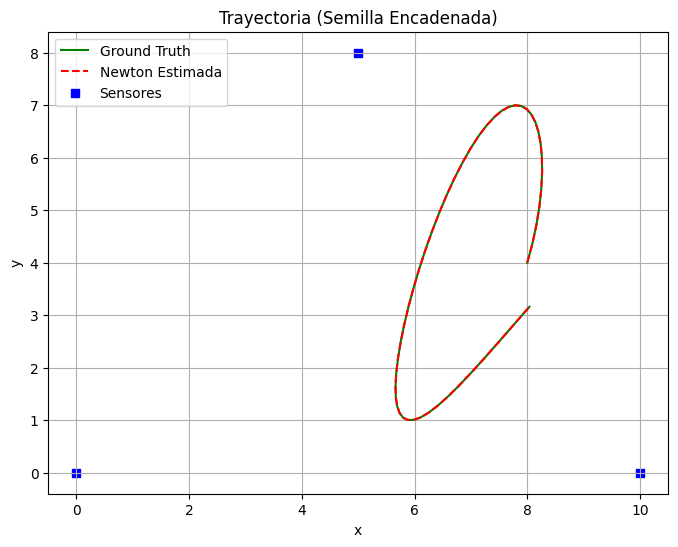

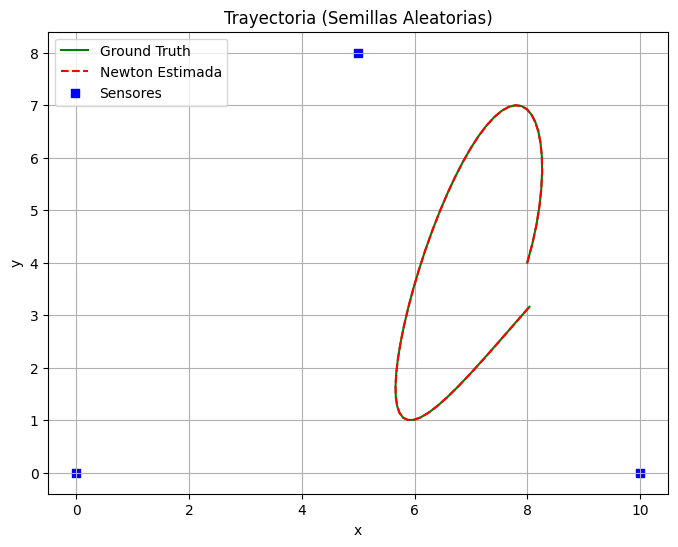

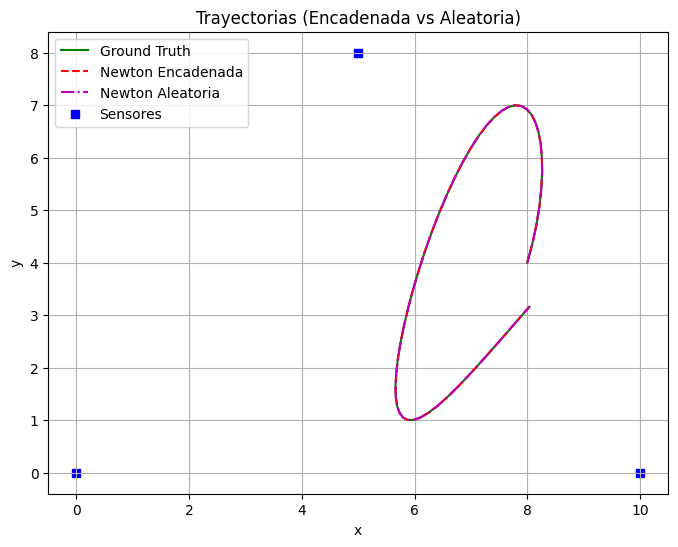

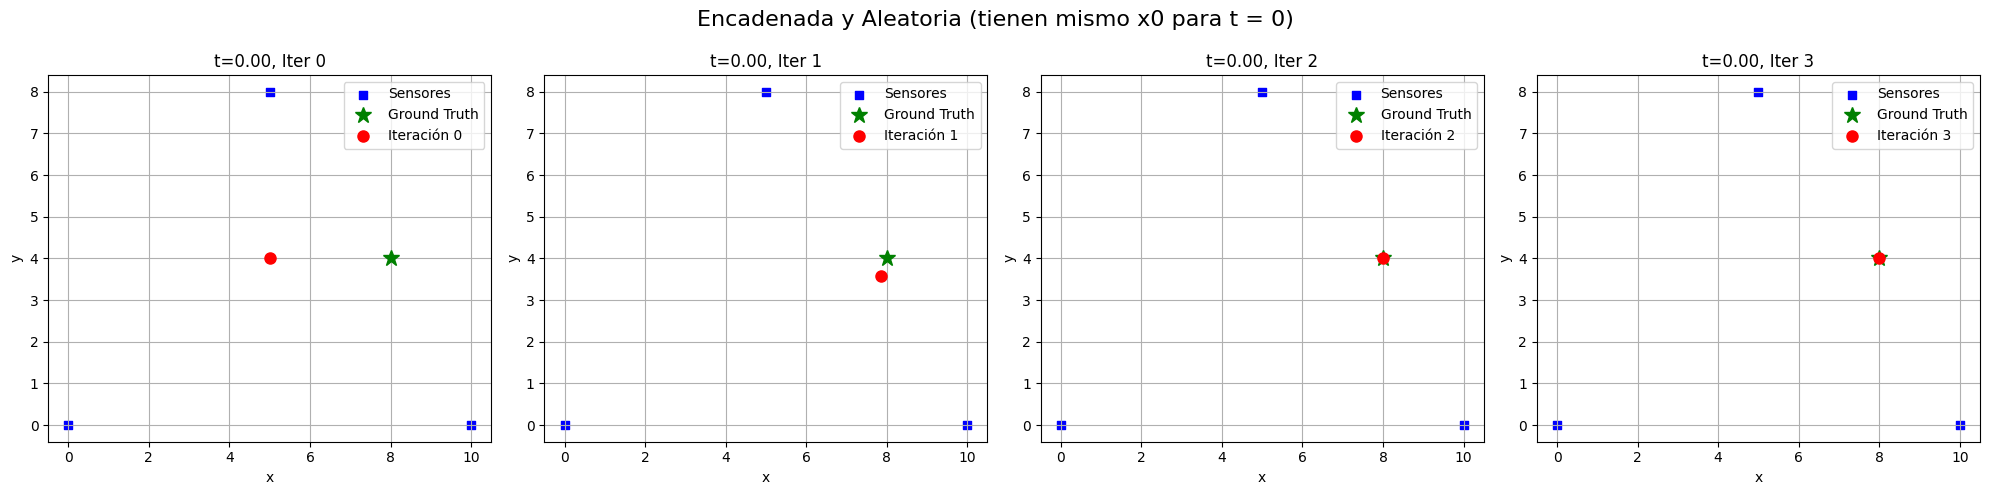

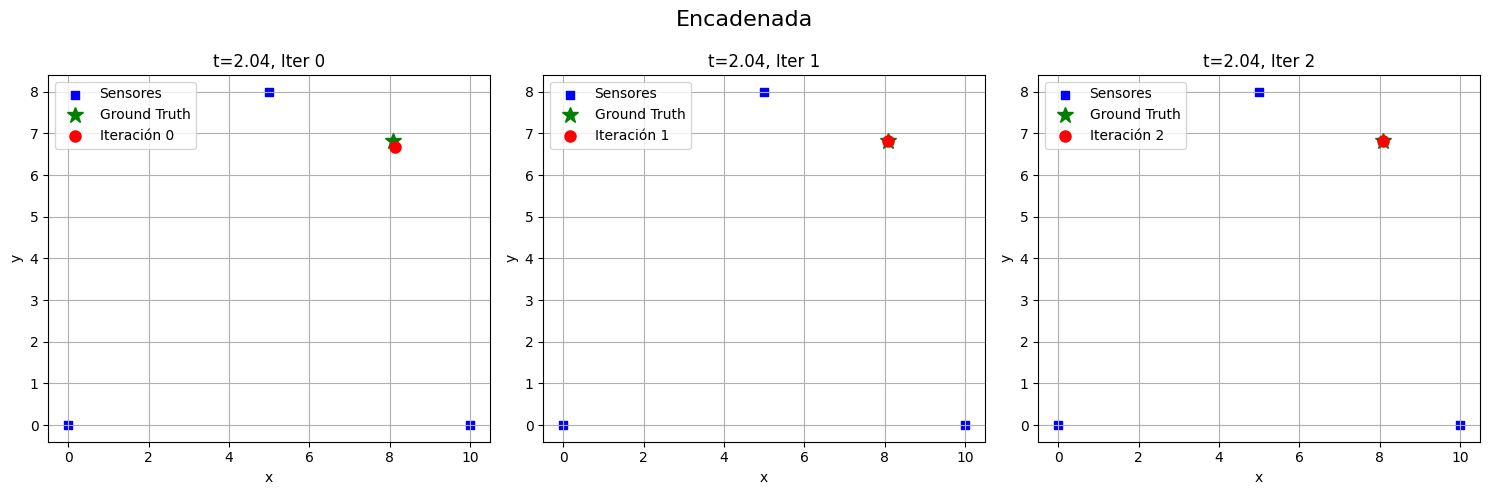

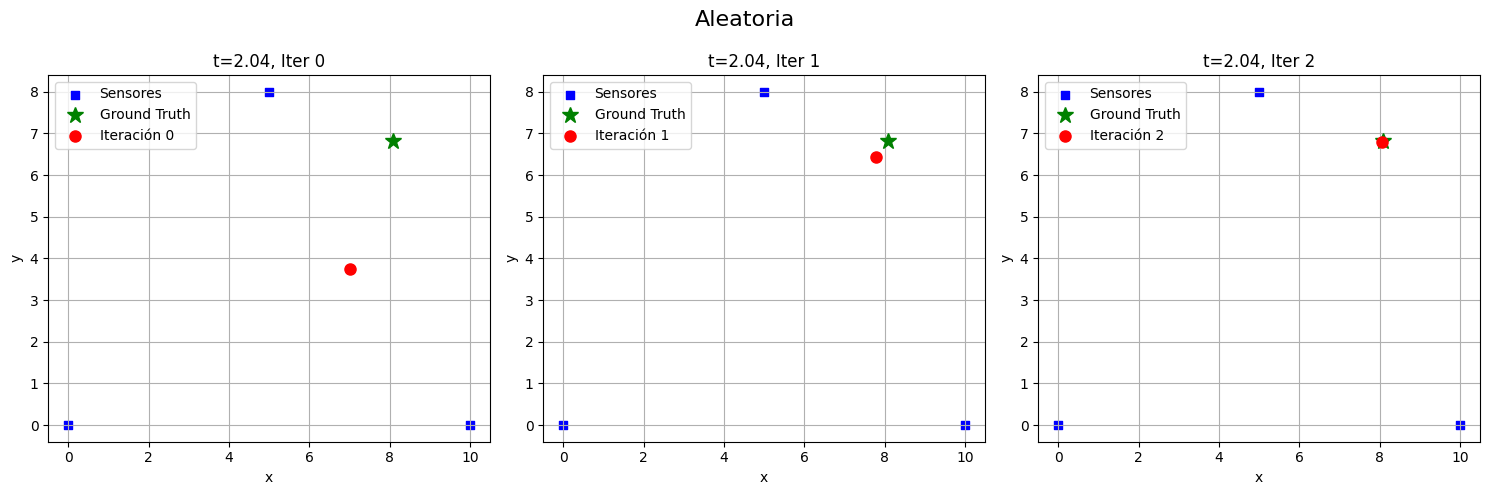

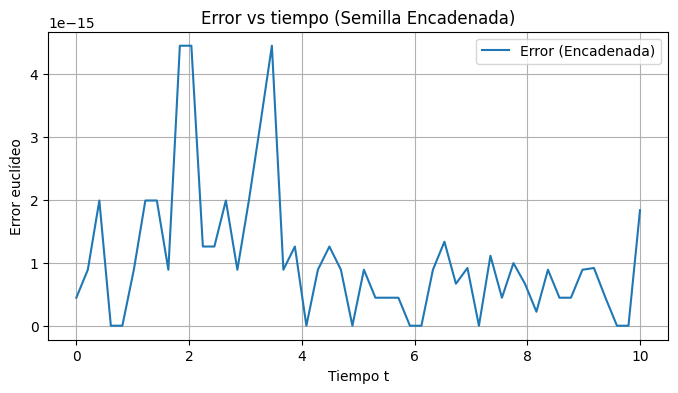

Error (Encadenada) -> max: 4.44089e-15 en t=1.83673, prom: 1.06908e-15


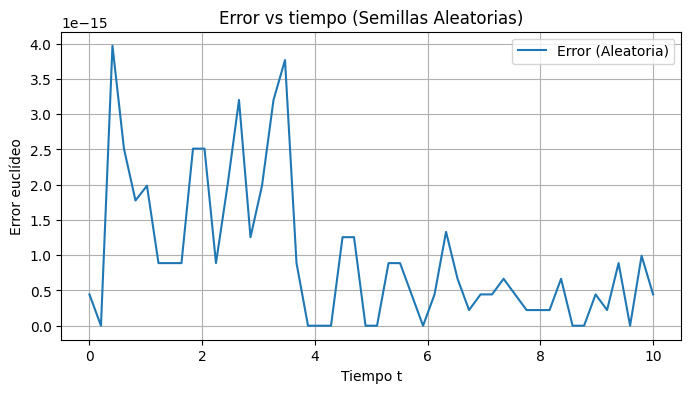

Error (Aleatoria) -> max: 3.97205e-15 en t=0.408163, prom: 9.85523e-16


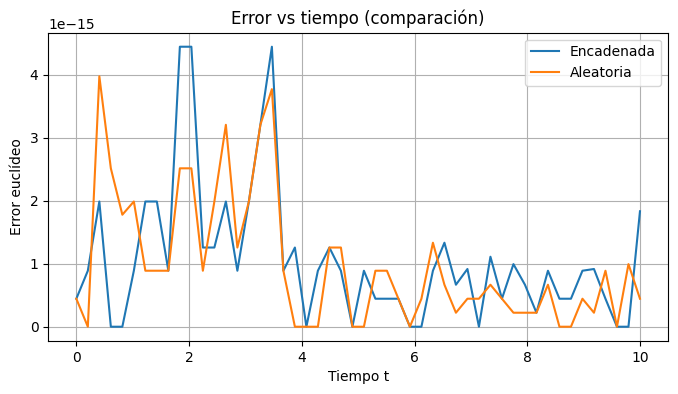

In [58]:
import numpy as np

def plot_trajectory(ground_truth, traj, sensor_positions, title="Trayectoria"):
    plt.figure(figsize=(8,6))
    plt.plot(ground_truth[:,0], ground_truth[:,1], 'g-', label="Ground Truth")
    plt.plot(traj[:,0],          traj[:,1],          'r--', label="Newton Estimada")
    plt.scatter(sensor_positions[:,0], sensor_positions[:,1],
                c="blue", marker="s", label="Sensores")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title)
    plt.legend(); plt.grid(True)
    plt.show()

def plot_trajectory_both(ground_truth, trajA, trajB, sensor_positions,
                         labelA="Encadenada", labelB="Aleatoria",
                         title="Trayectorias (comparación)"):
    plt.figure(figsize=(8,6))
    plt.plot(ground_truth[:,0], ground_truth[:,1], 'g-', label="Ground Truth")
    plt.plot(trajA[:,0],        trajA[:,1],        'r--', label=f"Newton {labelA}")
    plt.plot(trajB[:,0],        trajB[:,1],        'm-.', label=f"Newton {labelB}")
    plt.scatter(sensor_positions[:,0], sensor_positions[:,1],
                c="blue", marker="s", label="Sensores")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title(title)
    plt.legend(); plt.grid(True)
    plt.show()

def plot_newton_evolution(idx, histories, ground_truth, times, sensor_positions, num_iters=3,
                          title_prefix="Evolución Newton"):
    hist = histories[idx]
    fig, axes = plt.subplots(1, num_iters, figsize=(5*num_iters, 5))
    if num_iters == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        if i < len(hist):
            ax.scatter(sensor_positions[:,0], sensor_positions[:,1],
                       c="blue", marker="s", label="Sensores")
            ax.plot(ground_truth[idx,0], ground_truth[idx,1],
                    'g*', markersize=12, label="Ground Truth")
            ax.plot(hist[i,0], hist[i,1], 'ro', markersize=8, label=f"Iteración {i}")
            ax.set_title(f"t={times[idx]:.2f}, Iter {i}")
            ax.set_xlabel("x"); ax.set_ylabel("y")
            ax.legend(); ax.grid(True)
        else:
            ax.axis("off")
    plt.tight_layout()
    fig.suptitle(title_prefix, fontsize=16)  
    plt.subplots_adjust(top=0.85)  
    plt.show()

def plot_error(times, traj, ground_truth, label="Error", title="Error vs tiempo"):
    errors = np.linalg.norm(traj - ground_truth, axis=1)
    plt.figure(figsize=(8,4))
    plt.plot(times, errors, '-', label=label)
    plt.xlabel("Tiempo t"); plt.ylabel("Error euclídeo")
    plt.title(title)
    plt.legend(); plt.grid(True)
    plt.show()
    print(f"{label} -> max: {errors.max():.6g} en t={times[errors.argmax()]:.6g}, "
          f"prom: {errors.mean():.6g}")

# --- 1) Trayectorias por separado ---
plot_trajectory(ground_truth, traj_chain, sensor_positions,
                title="Trayectoria (Semilla Encadenada)")
plot_trajectory(ground_truth, traj_rand,  sensor_positions,
                title="Trayectoria (Semillas Aleatorias)")

# --- 2) Trayectorias comparadas en un mismo gráfico ---
plot_trajectory_both(ground_truth, traj_chain, traj_rand, sensor_positions,
                     labelA="Encadenada", labelB="Aleatoria",
                     title="Trayectorias (Encadenada vs Aleatoria)")

# --- 3) Evolución paso a paso en un tiempo particular (para cada variante) ---
# Elegí los índices y cuántas iteraciones mostrar (incluye la semilla como iter 0)
plot_newton_evolution(idx=0,  histories=histories_chain, ground_truth=ground_truth,
                      times=times, sensor_positions=sensor_positions, num_iters=4,
                      title_prefix="Encadenada y Aleatoria (tienen mismo x0 para t = 0)")
plot_newton_evolution(idx=10, histories=histories_chain, ground_truth=ground_truth,
                      times=times, sensor_positions=sensor_positions, num_iters=3,
                      title_prefix="Encadenada")
plot_newton_evolution(idx=10, histories=histories_rand, ground_truth=ground_truth,
                      times=times, sensor_positions=sensor_positions, num_iters=3,
                      title_prefix="Aleatoria")

# --- 4) Errores vs tiempo (una figura para cada variante) ---
plot_error(times, traj_chain, ground_truth,
           label="Error (Encadenada)", title="Error vs tiempo (Semilla Encadenada)")
plot_error(times, traj_rand,  ground_truth,
           label="Error (Aleatoria)",  title="Error vs tiempo (Semillas Aleatorias)")

# --- 5) (Opcional) Comparar errores de ambas en un mismo gráfico ---
errors_chain = np.linalg.norm(traj_chain - ground_truth, axis=1)
errors_rand  = np.linalg.norm(traj_rand  - ground_truth, axis=1)
plt.figure(figsize=(8,4))
plt.plot(times, errors_chain, '-', label="Encadenada")
plt.plot(times, errors_rand,  '-', label="Aleatoria")
plt.xlabel("Tiempo t"); plt.ylabel("Error euclídeo")
plt.title("Error vs tiempo (comparación)")
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# Orden de convergencia -> ek/e(k-1)